In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from yaml_io import *
from prepare_nest_parameters import *
from nest_reset_create_connect_simulate import *
from activity_analysis import *
from synaptic_io import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
is_verbose = False
#copy configuration yamls in specified output directory
directories_and_list_of_yamls =\
    read_basic_directories_and_list_of_yamls(is_verbose)
copy_yamls_in_output_dir(directories_and_list_of_yamls, is_verbose)

is_verbose = True
#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

#prepare all simulation parameters
nest_pms={}
nest_pms = nest_parameters_preparation(times, config, is_verbose, nest_pms)
print("nest_pms",nest_pms)

in read_directories_yaml: verbose mode is False
Directory '/Users/paolucci/github_projects/WTA-states/2024-0822-plasticity-on-and-off-awake-training' created.
in read_sim_and_recording_times_yaml: verbose mode is True
IN read_sim_and_recording_times_yaml:
opening file: basic_sim_and_recording_times.yaml
DEFAULT CONFIG (possibly to be TUNED): {'sim_pms': {'stop_ms': 45000.0, 'resolution_ms': 0.1}, 'recording_pms': {'start_ms': 5000.0, 'stop_ms': 45000.0}, 'events_pms': [{'action': {'kind': 'store_intra_assembly_syn', 'syn_file_name': 'syn_matrix-initial'}, 'sim_period_ms': 3000.0}, {'action': {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2, 'syn_file_name_after': 'syn_matrix-after_first_disconnection'}, 'sim_period_ms': 2000.0}, {'action': {'kind': 'plastic_intra_exc_pop_syn_ON', 'target_exc_pop': 2, 'W_max_factor': 2.0, 'syn_file_name_after': 'syn_matrix-after_plasticity_switch_ON'}, 'sim_period_ms': 2000.0}, {'action': {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_

In [3]:
NEST_version = nest.__version__
if NEST_version == "3.7.0" and nest_pms["use_single_compartment_environment"]==False:
    print("ASSERTION ERROR: Ca-AdEx multi-compartment neuron not supported by this NEST version", NEST_version)
    assert(False)
is_verbose=False
num_threads=4
sim_completed, spike_recorders, inh_spike_recorder = nest_reset_create_connect_simulate(nest_pms,num_threads, is_verbose)
print("sim_completed", sim_completed)

IN nest_reset_create_connect_simulate: use_single_compartment_environment =
Aug 22 15:58:34 SimulationManager::set_status [Info]: 
 True
    Temporal resolution changed from 0.1 to 0.1 ms.
in nest_..._simulate: just before nest.Simulate
nest_pms['events_pms'] [{'action': {'kind': 'store_intra_assembly_syn', 'syn_file_name': 'syn_matrix-initial'}, 'sim_period_ms': 3000.0}, {'action': {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2, 'syn_file_name_after': 'syn_matrix-after_first_disconnection'}, 'sim_period_ms': 2000.0}, {'action': {'kind': 'plastic_intra_exc_pop_syn_ON', 'target_exc_pop': 2, 'W_max_factor': 2.0, 'syn_file_name_after': 'syn_matrix-after_plasticity_switch_ON'}, 'sim_period_ms': 2000.0}, {'action': {'kind': 'disconnect_intra_exc_pop_syn', 'target_exc_pop': 2, 'syn_file_name_before': 'syn_matrix-end_of_plasticity', 'syn_file_name_after': 'syn_matrix-after_second_disconnection'}, 'sim_period_ms': 1000.0}]
ACTION {'kind': 'store_intra_assembly_syn', 'syn_file_nam

In [4]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [5]:
#before analysis, preliminary sim look 
is_verbose=True
preliminary_sim_look(is_verbose, nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 43.5 from sender 20
pop 0 last recorded event at time 44837.8 from sender 19
pop 0 total_exc_pop_spikes= 4215
pop 0 average_exc_pop_firing_rate_Hz= 4.683333333333334 Hz
pop 1 first recorded event at time 40.2 from sender 28
pop 1 last recorded event at time 44968.3 from sender 35
pop 1 total_exc_pop_spikes= 4151
pop 1 average_exc_pop_firing_rate_Hz= 4.612222222222223 Hz
pop 2 first recorded event at time 43.9 from sender 44
pop 2 last recorded event at time 44943.3 from sender 43
pop 2 total_exc_pop_spikes= 3819
pop 2 average_exc_pop_firing_rate_Hz= 4.243333333333333 Hz
pop 3 first recorded event at time 82.10000000000001 from sender 72
pop 3 last recorded event at time 44958.8 from sender 71
pop 3 total_exc_pop_spikes= 4106
pop 3 average_exc_pop_firing_rate_Hz= 4.562222222222223 Hz
INHIBITORIES 3 first recorded event at time 42.0 from sender 84
INHIBITORIES 3 last recorded event at time 44965.3 from sender 99
INHIBITORIES 3 total_inh_pop_spikes= 2602

In [6]:
is_verbose=False
#here we prepare all the parameters for the following analysis and print
crop_pms, plot_pms, sampling_pms, analysis_pms =\
    prepare_crop_plot_sampling_activityAnalysis_parameters(directories_and_list_of_yamls, nest_pms, is_verbose)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)

in read_crop_and_plot_yaml: verbose mode is False
---RECORDING INTERVAL---
start recording at time 0.0 ms
stop recording at time 45000.0 ms
recording_duration 45000.0 ms
---CROPPING INTERVAL
crop start at time 0.0 ms
crop stop at time 45000.0 ms
crop duration 45000.0 ms
---HIGH FREQ analysis AND (spikes) 
spectogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)
(low freq) spectrogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 4000.0 ms


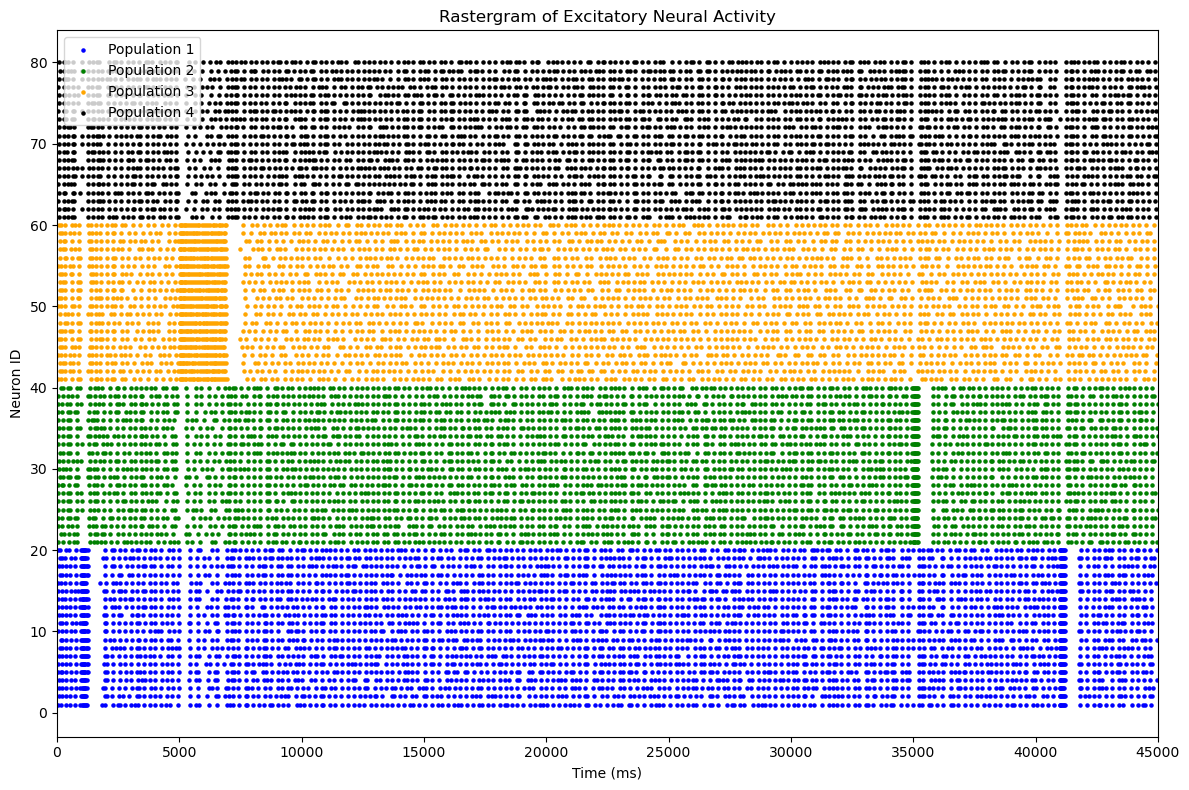

FROM SPIKE-LIKE WAVEFORMS:
--------------------------


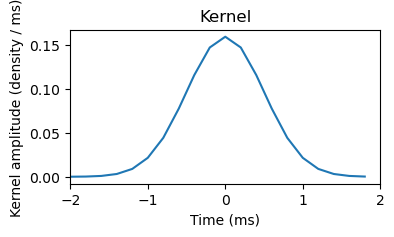

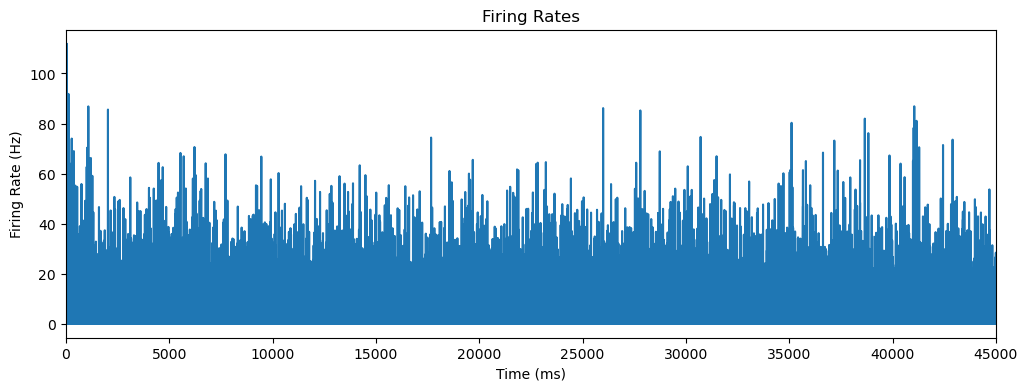

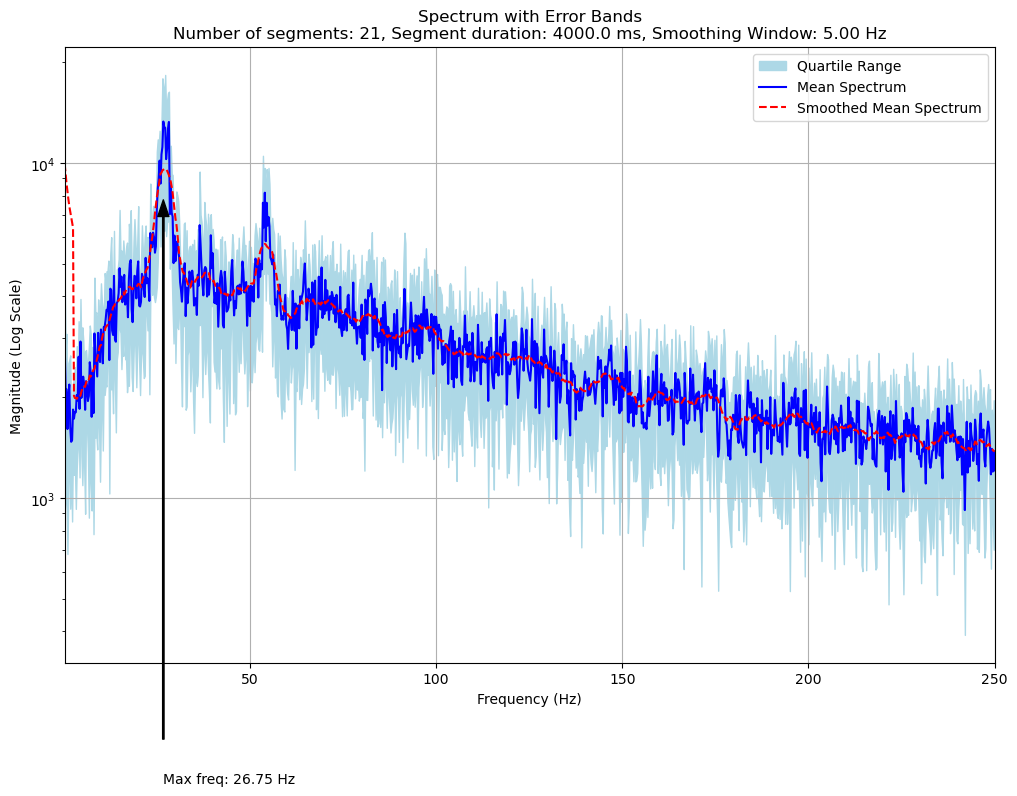

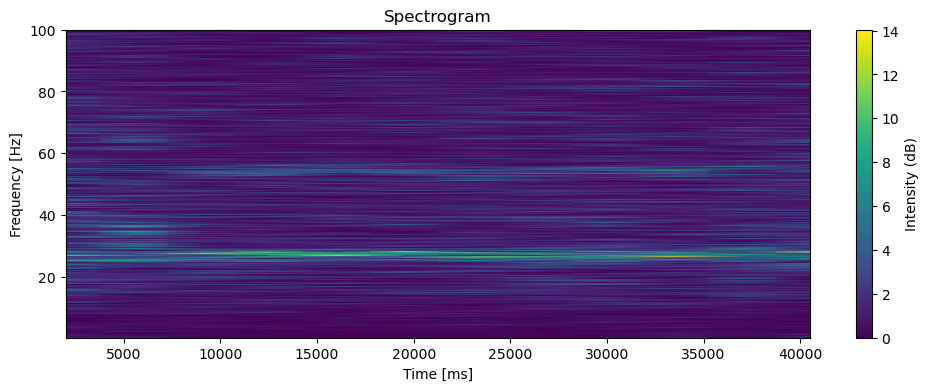

--------------------------
FROM TISSUE-LIKE WAVEFORMS 
--------------------------


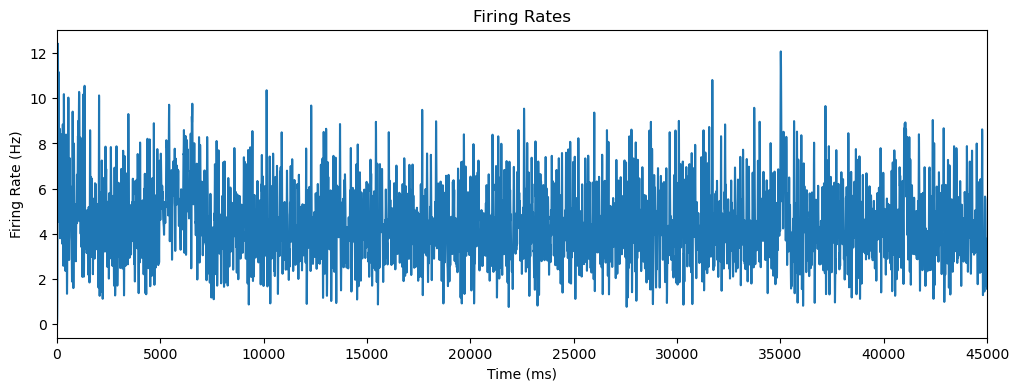

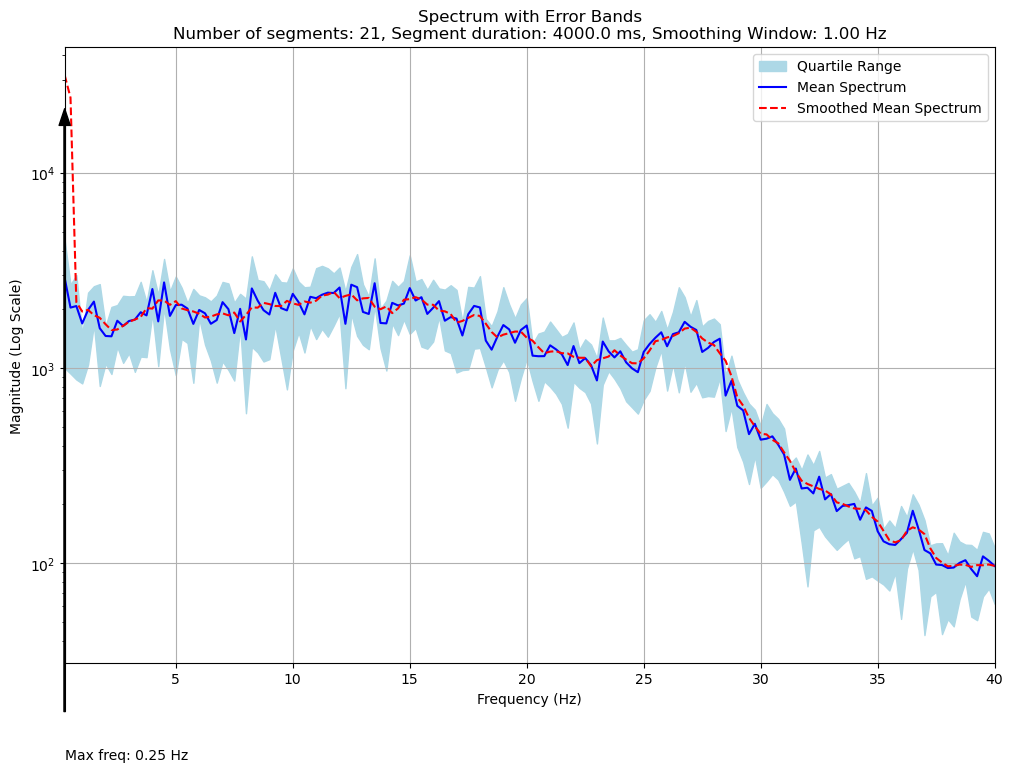

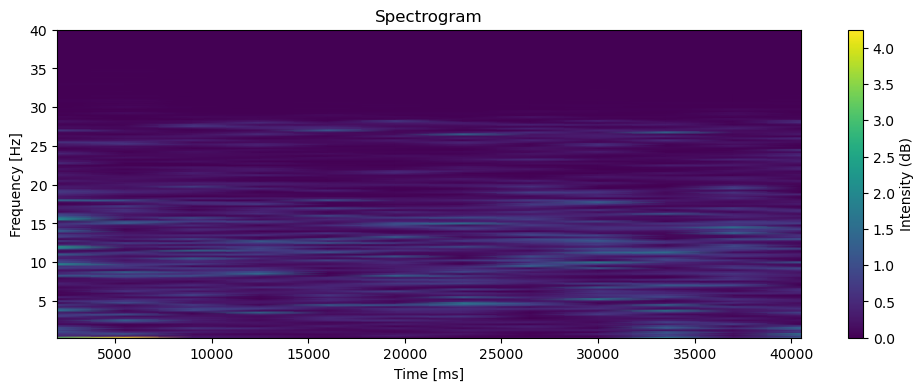

In [7]:
is_verbose=False
#launches all analysis
#produces from both spike-like waveforms and tissue-like responses
#PLEASE use the basic_ and tune_crop_and_plot.yaml to select plots and parameters 
produce_rastegrams_rates_spectra_spectrograms(directories_and_list_of_yamls,\
    nest_pms, crop_pms, plot_pms, analysis_pms, cropped_events, cropped_inh_events, is_verbose)

In [9]:
verbose=True
list_of_syn_matrix_file_names=['syn_matrix-initial',
                               'syn_matrix-after_first_disconnection',
                               'syn_matrix-after_plasticity_switch_ON',
                               'syn_matrix-end_of_plasticity',
                               'syn_matrix-after_second_disconnection']
# loading of synaptic matrices
for file_name in list_of_syn_matrix_file_names:
    array_of_dicts=load_intra_assembly_syn(file_name, verbose) 

in load_intra_assembly_syns:
reading from file: syn_matrix-initial
Population 0:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 1:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 2:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 3:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
in load_intra_assembly_syns:
reading from file: syn_matrix-after_first_disconnection
Population 0:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 1:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 2:
  Mean Weight: 0.0000
  Standard Deviation: 0.0000
Population 3:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
in load_intra_assembly_syns:
reading from file: syn_matrix-after_plasticity_switch_ON
Population 0:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 1:
  Mean Weight: 9.5000
  Standard Deviation: 0.0000
Population 2:
  Mean Weight: 0.0050
  Standard Deviation: 0.0050
Population 3:
  Mean Weight: 9.5000
  Standard 